[User Struggles &lt;](Struggles.ipynb) | [&gt; Use of AWS](AWS.ipynb)

# What can we learn about API design for data science?

There are a lot of different ways of spelling out functionality in APIs and some of them are painful, while others are highly usable. We may be able to learn things about API design by looking at what APIs people are using and how. We can help to design good APIs by advising the granularity questions (lots of small objects/functions, or a few with lots or arguments)? 

## Results Summary:
- Code cells
    - On average, a code cell is 10.37 lines long (median = 6). The longest cell is 40,759 lines long.
- Variables
    - On average, there are 5.15 object definitions in a notebook. Median = 0.0. (Among notebooks with at least one object, Median = 10.0)
- Parameters
    - Across all function calls, there are an average of 1.057 arguments per function. 
    - On average, a call to a user defined function has 1.65 parameters.
    - On average, a call to a non user-defined function has 1.017 parameters.
    - This is a statistically significant difference. We are 95% confident that the true average number of parameters in user-defined function calls is between 0.62 and 0.64 higher than the average number of parameters in non user-defined function calls.

- Functions
    - Across all function calls, there are an average of 1.13 arguments per function.
-----


# Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from collections import deque
import scipy.stats as st
import ast
import astpretty
import pickle
import re
import os

import load_data

Load dataframes

In [2]:
notebooks_temp = load_data.load_notebooks()
repos_temp = load_data.load_repos()

Notebooks loaded in 0:00:24.637463
Repos loaded in 0:00:05.524399


Load aggregated dataframes. Code used to create them is in [aggregate.py](aggregate.py).

In [3]:
all_objects_df_temp = load_data.load_objects()

Objects loaded in 0:01:18.018478


In [4]:
cell_stats_df_temp = load_data.load_cell_stats()
cell_types_df_temp = load_data.load_cell_types()
function_defs_df_temp = load_data.load_function_defs()
function_use_df_temp = load_data.load_function_use()
all_objects_df_temp = load_data.load_objects()
errors_df_temp = load_data.load_errors()
nb_imports_temp = load_data.load_nb_imports()

Cell stats loaded in 0:00:05.644303
Cell types loaded in 0:00:05.168389
Function definitions loaded in 0:00:03.768162
Function uses loaded in 0:00:56.736603
Objects loaded in 0:01:07.104579
Errors loaded in 0:00:24.445181
Notebook imports loaded in 0:00:44.575160


Load list of lines of code per code cell.

In [5]:
lines_per_code_cell = load_data.load_lines()

Lines per code cell loaded in 0:00:00.372101


Load statuses. For some analysis we will remove files that couldn't be parsed with the python abstract syntax tree.

In [6]:
statuses_df_temp = load_data.load_statuses()

Statuses loaded in 0:00:03.177732


---
# Tidy Data

### Only looking at Python notebooks

In [11]:
notebooks = notebooks_temp.copy()[notebooks_temp.lang_name == 'python'].reset_index(drop=True)

In [12]:
print("{0:,} ({1}%) of notebooks were written in Python. The remaining {2}% have been removed.".format(
    len(notebooks),
    round(100*len(notebooks)/len(notebooks_temp), 2),
    round(100 - 100*len(notebooks)/len(notebooks_temp), 2)
))

4,115,126 (95.91%) of notebooks were written in Python. The remaining 4.09% have been removed.


### Needed for some analysis: limit to notebooks that could be parsed with Python ast

In [14]:
statuses_df = statuses_df_temp.copy()[statuses_df_temp.syntax == True].reset_index(drop=True)
notebooks_ast = notebooks.copy()[notebooks.file.isin(statuses_df.file)].reset_index(drop=True)

In [15]:
print("{0}% of python notebooks were able to be parsed by Python AST.".format(
    round(100*len(notebooks_ast)/len(notebooks), 2),
    round(100 - 100*len(notebooks_ast)/len(notebooks), 2)
))

56.69% of python notebooks were able to be parsed by Python AST.


In [16]:
print("{0}% of python 3 notebooks were able to be parsed by Python AST.".format(
    round(100*len(notebooks_ast)/len(notebooks[[str(l).startswith('3') for l in notebooks.lang_version]&(notebooks.lang_name == 'python')]), 2),
    round(100 - 100*len(notebooks_ast)/len(notebooks[[str(l).startswith('3') for l in notebooks.lang_version]&(notebooks.lang_name == 'python')]), 2)
))

73.61% of python 3 notebooks were able to be parsed by Python AST.


### Update repos and aggregated dataframe to reflect notebooks in question

All python notebooks not in ipynb checkpoints

In [17]:
cell_stats_df = cell_stats_df_temp.copy()[cell_stats_df_temp.file.isin(notebooks.file)]
cell_types_df = cell_types_df_temp.copy()[cell_types_df_temp.file.isin(notebooks.file)]
repos = repos_temp.copy()[repos_temp.repo_id.isin(notebooks.repo_id)]
errors_df = errors_df_temp.copy()[errors_df_temp.file.isin(notebooks.file)]
nb_imports = nb_imports_temp.copy()[nb_imports_temp.file.isin(nb_imports_temp.file)]

Python notebooks in ipynb checkpoints that were able to be parsed

In [18]:
function_defs_df = function_defs_df_temp.copy()[function_defs_df_temp.file.isin(notebooks_ast.file)]
function_use_df = function_use_df_temp.copy()[function_use_df_temp.file.isin(notebooks_ast.file)]
all_objects_df = all_objects_df_temp.copy()[all_objects_df_temp.file.isin(notebooks_ast.file)]

### Delete temp dataframes to save space

In [19]:
del notebooks_temp
del repos_temp
del cell_stats_df_temp
del cell_types_df_temp
del function_defs_df_temp
del function_use_df_temp
del all_objects_df_temp
del errors_df_temp

---
# Manipulate Data

Add num_errors to errors dataframe

In [17]:
errors_df['num_errors'] = [len(e) for e in errors_df['error_names']]

Add num_objects column to objects dataframe

In [18]:
all_objects_df['num_objects'] = [len(obj) for obj in all_objects_df['objects']]

Group function definitions by notebook

In [19]:
function_defs_stats_df = function_defs_df.groupby('file')['function'].count().reset_index().merge(
    function_defs_df.groupby('file')['parameters'].sum().reset_index(),
    on = 'file'
)


---
# Visualizations and Statistics

## How long are code cells?

In [20]:
pd.Series(lines_per_code_cell).aggregate(['mean','median','min','max'])


mean         10.296976
median        6.111111
min           0.000000
max       40759.000000
dtype: float64

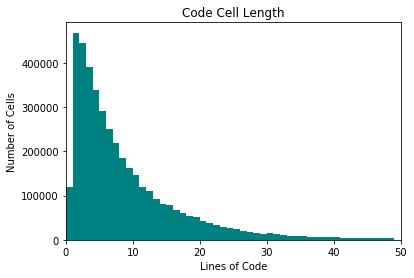

In [21]:
plt.hist(lines_per_code_cell, bins = range(50), color = 'teal')
plt.xlim(0,50)
plt.xlabel('Lines of Code')
plt.ylabel('Number of Cells')
plt.title('Code Cell Length')
plt.show()


On average, code cells have 10.30 lines of code. The typical code cell has 6 lines of code (median).

## What is a typical number of objects in a notebook?

Calculate summary statistics for the number of objects in each notebook. Only consider 'name' assigments as objects. Setting the value in a list or data frame (subscript) and altering the attributes of an object (attribute) should not count as object assignments

In [22]:
mean_objs = all_objects_df.num_objects.mean()
median_objs = all_objects_df.num_objects.median()
median_objs_with = all_objects_df[all_objects_df!=0].num_objects.median()
print('On average, among notebooks that were able to be parsed with Python abstract syntax tree, there are {0} object definitions in a notebook. Median = {1}. (Among notebooks with at least one object, Median = {2})'.format(
    round(mean_objs, 2), median_objs, median_objs_with
))


On average, among notebooks that were able to be parsed with Python abstract syntax tree, there are 20.72 object definitions in a notebook. Median = 13.0. (Among notebooks with at least one object, Median = 14.0)


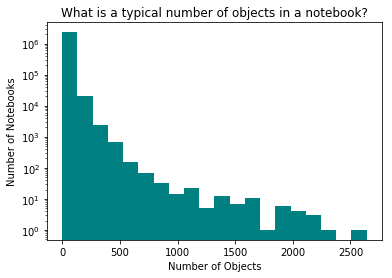

In [23]:
plt.hist(all_objects_df.num_objects, bins = 20, color='teal')
plt.title('What is a typical number of objects in a notebook?')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Notebooks')
plt.yscale('log')
plt.show()

## How many functions are called?

In [24]:
function_use_df['unique_user_def'] = [len(set(user_def)) for user_def in function_use_df.user_def]
function_use_df['unique_not_user_def'] = [len(set(not_user_def)) for not_user_def in function_use_df.not_user_def]
function_use_df['unique'] = function_use_df['unique_user_def'] + function_use_df['unique_not_user_def']

In [25]:
print('There are an average of {0} unique functions called in each notebook (median = {1}).'.format(
    round(function_use_df.unique.mean(), 2),
    function_use_df.unique.median()
))

print('There are an average of {0} unique user-defined functions called in each notebook (median = {1}).'.format(
    round(function_use_df.unique_user_def.mean(), 2),
    function_use_df.unique_user_def.median()
))

print('There are an average of {0} unique not user-defined functions called in each notebook (median = {1}).'.format(
    round(function_use_df.unique_not_user_def.mean(), 2),
    function_use_df.unique_not_user_def.median()
))

There are an average of 28.17 unique functions called in each notebook (median = 21.0).
There are an average of 1.73 unique user-defined functions called in each notebook (median = 0.0).
There are an average of 26.44 unique not user-defined functions called in each notebook (median = 19.0).


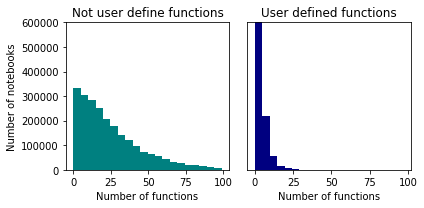

1267459 (54%) notebooks have no user defined functions.


In [26]:
fig = plt.figure(figsize = (6, 3))
plt.subplot(1,2,1)
plt.hist(function_use_df[function_use_df.unique_not_user_def < 100].unique_not_user_def, color = 'teal', bins = 20)
plt.ylim(0, 600000)
plt.title('Not user define functions')
plt.ylabel('Number of notebooks')
plt.xlabel('Number of functions')

plt.subplot(1,2,2)
plt.hist(function_use_df[function_use_df.unique_user_def < 100].unique_user_def, color = 'navy', bins = 20)
plt.ylim(0, 600000)
plt.yticks([],[])
plt.title('User defined functions')
plt.xlabel('Number of functions')

plt.tight_layout()
plt.show()

print("{0} ({1}%) notebooks have no user defined functions.".format(
    sum(function_use_df.unique_user_def == 0),
    round(100*sum(function_use_df.unique_user_def == 0)/len(function_use_df))
))

### Is number of functions used associated with number of errors in a notebook?

In [27]:
errors_funcs_df = errors_df[['file','num_errors']].merge(function_use_df[['file','unique','unique_user_def','parameters']], on = 'file')
errors_funcs_df[['num_errors','unique']].corr()

,num_errors,unique
num_errors,1.000000,0.018886
unique,0.018886,1.000000


The very weak correlation of 0.019 provides no evidence that the number of function calls in a notebook is associated with the number of errors in a notebook.

### Is number of functions defined associated with number of errors in a notebook?

In [28]:
errors_funcs_df[['num_errors','unique_user_def']].corr()

,num_errors,unique_user_def
num_errors,1.000000,0.012541
unique_user_def,0.012541,1.000000


The very weak correlation of 0.01 provides no evidence that the number of user defined functions in a notebook is associated with the number of errors in a notebook.

### Is the average number of parameters associated wth the number of errors in a notebook?

In [29]:
errors_funcs_df['avg_params'] = [sum(p)/len(p) if len(p) > 0 else None for p in errors_funcs_df.parameters]
errors_funcs_df[['num_errors','avg_params']].corr()

,num_errors,avg_params
num_errors,1.000000,-0.003806
avg_params,-0.003806,1.000000


The very weak correlation of -0.004 provides no evidence that the average number of parameters of function calls in a notebook is associated with the number of errors in a notebook.

## How many arguments are typical to pass into functions?

Across all function calls, there are an average of 0.99 arguments per function.


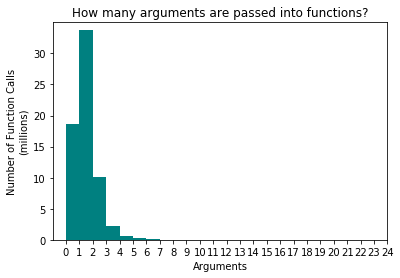

In [40]:
# 35 seconds
all_params = load_data.flatten(function_use_df.parameters)

print("Across all function calls, there are an average of {0} arguments per function.".format(
    round(pd.Series(all_params).mean(), 2)
))

param_counts = pd.Series(all_params).value_counts().reset_index().rename(
    columns={'index':'Arguments',0:'Count'}
)

plt.hist(pd.Series(all_params), bins = range(25), color = 'teal')
plt.xlabel('Arguments')
plt.xlim(-1, 20)
plt.ylim(0, 35000000)
plt.yticks(range(0, 35000000, 5000000), range(0, 35, 5))
plt.xticks(range(25))
plt.title('How many arguments are passed into functions?')
plt.ylabel('Number of Function Calls\n(millions)')
plt.show()

### Parameters of user-defined functions

#### Based on Definitions

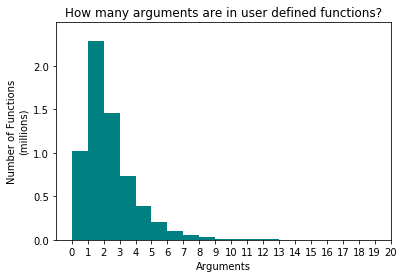

In [45]:
# # 2 min
# start = datetime.datetime.now()
# function_defs_stats_df['avg_params'] = [
#     row.parameters / row.function 
#     if row.function != 0 else 0 
#     for _, row in function_defs_stats_df.iterrows()
# ]
# end = datetime.datetime.now()
# print(end - start)

# user_mean_params = function_defs_stats_df.avg_params.mean()

# print("On average, a user defined function has {0} parameters.".format(
#     round(user_mean_params, 2)
# ))

plt.hist(
    function_defs_df.parameters,
    color = 'teal',
    bins = range(25)
)
plt.xticks(range(25))
plt.xlim(-1, 20)
plt.ylim(0, 2500000)
plt.yticks(range(0, 2500000, 500000), pd.Series(range(0, 25, 5))/10)
plt.title('How many arguments are in user defined functions?')
plt.xlabel('Arguments')
plt.ylabel('Number of Functions\n(millions)')
plt.show()

[User Struggles &lt;](Struggles.ipynb) | [&gt; Use of AWS](AWS.ipynb)